In [1]:
import os
import pickle
import numpy as np
import numpy.linalg as la

import PIL.Image
import PIL.ImageSequence

import moviepy
import moviepy.editor
import math
import glob
import csv
from functools import partial
import time
import collections

import sys
sys.path.append("stylegan2")

import run_projector
import projector
import dnnlib
import dnnlib.tflib as tflib

import tensorflow as tf

import keras
from keras.applications.vgg16 import VGG16, preprocess_input

from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, ElasticNet
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA

import colorsys
import re
import copy

from IPython.display import display, clear_output
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import matplotlib.pyplot as plt
import glob
import gc

Using TensorFlow backend.


In [2]:
# If this doesn't say 1.14.0, it probably will not work. Stylegan2 is picky.
# Additionally, you'll need some compiler so nvcc can work (add the path in custom_ops.py if needed)
# In summary, the best time for google to stop making breaking changes to tensorflow was 2 years ago
tf.__version__

'1.14.0'

In [3]:
##
# 0. Load network snapshots
##

# From https://mega.nz/#!PeIi2ayb!xoRtjTXyXuvgDxSsSMn-cOh-Zux9493zqdxwVMaAzp4 - gwern animefaces stylegan2
input_sg_name = "stylegan2_animeface_model/2020-01-11-skylion-stylegan2-animeportraits-networksnapshot-024664.pkl"

tflib.init_tf()

# Load pre-trained network.
with open(input_sg_name, 'rb') as f:
    # _G = Instantaneous snapshot of the generator. Mainly useful for resuming a previous training run.
    # _D = Instantaneous snapshot of the discriminator. Mainly useful for resuming a previous training run.
    # Gs = Long-term average of the generator. Yields higher-quality results than the instantaneous snapshot.    
    _G, _D, Gs = pickle.load(f)
        
# Print network details.
Gs.print_layers()
_D.print_layers()

# For projection
proj = projector.Projector()
proj.set_network(Gs)

Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Loading... Done.

Gs                            Params    OutputShape         WeightShape     
---                           ---       ---                 ---             
latents_in                    -         (?, 512)            -               
labels_in                     -         (?, 0)              -               
lod                           -         ()                  -               
dlatent_avg                   -         (512,)              -               
G_mapping/latents_in          -         (?, 512)            -               
G_mapping/labels_in           -         (?, 0)              -               
G_mapping/Normalize           -         (?, 512)            -               
G_mapping/Dense0              262656    (?, 512)            (512, 512)      
G_mapping/Dense1              262656    (?, 512)            (512,

In [4]:
##
# 1. Plain generation
##

# "Ellipse around a point but probably a circle since it's 512 dimensions" laten
def circ_generator(latents_interpolate):
    radius = 40.0

    latents_axis_x = (latents_a - latents_b).flatten() / la.norm(latents_a - latents_b)
    latents_axis_y = (latents_a - latents_c).flatten() / la.norm(latents_a - latents_c)

    latents_x = math.sin(math.pi * 2.0 * latents_interpolate) * radius
    latents_y = math.cos(math.pi * 2.0 * latents_interpolate) * radius

    latents = latents_a + latents_x * latents_axis_x + latents_y * latents_axis_y
    return latents

# Generate images from a list of latents
def generate_from_latents(latent_list, truncation_psi):
    array_list = []
    image_list = []
    for latents in latent_list:
        # Generate image.
        fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
        images = Gs.run(latents, None, truncation_psi=truncation_psi, randomize_noise=False, output_transform=fmt)
        array_list.append(images[0])
        image_list.append(PIL.Image.fromarray(images[0], 'RGB'))
        
    return array_list, image_list

def mse(x, y):
    return (np.square(x - y)).mean()

# Generate from a latent generator, keeping MSE between frames constant
def generate_from_generator_adaptive(gen_func):
    max_step = 1.0
    current_pos = 0.0
    
    change_min = 10.0
    change_max = 11.0
    
    fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    
    current_latent = gen_func(current_pos)
    current_image = Gs.run(current_latent, None, truncation_psi=0.5, randomize_noise=False, output_transform=fmt)[0]
    array_list = []
    
    while(current_pos < 1.0):
        array_list.append(current_image)
        
        lower = current_pos
        upper = current_pos + max_step
        current_pos = (upper + lower) / 2.0
        
        current_latent = gen_func(current_pos)
        current_image = images = Gs.run(current_latent, None, truncation_psi=0.5, randomize_noise=False, output_transform=fmt)[0]
        current_mse = mse(array_list[-1], current_image)
        
        while current_mse < change_min or current_mse > change_max:
            if current_mse < change_min:
                lower = current_pos
                current_pos = (upper + lower) / 2.0
            
            if current_mse > change_max:
                upper = current_pos
                current_pos = (upper + lower) / 2.0
                
            
            current_latent = gen_func(current_pos)
            current_image = images = Gs.run(current_latent, None, truncation_psi=0.5, randomize_noise=False, output_transform=fmt)[0]
            current_mse = mse(array_list[-1], current_image)
        print(current_pos, current_mse)
        
    return array_list

# We have to do truncation ourselves, since we're not using the combined network
def truncate(dlatents, truncation_psi, maxlayer = 16):
    dlatent_avg = tf.get_default_session().run(Gs.own_vars["dlatent_avg"])
    layer_idx = np.arange(16)[np.newaxis, :, np.newaxis]
    ones = np.ones(layer_idx.shape, dtype=np.float32)
    coefs = tf.where(layer_idx < maxlayer, truncation_psi * ones, ones)
    return tf.get_default_session().run(tflib.lerp(dlatent_avg, dlatents, coefs))

# Generate image with disentangled latents as input
def generate_images_from_dlatents(dlatents, truncation_psi = 1.0, randomize_noise = True):
    if not truncation_psi is None:
        dlatents_trunc = truncate(dlatents, truncation_psi)
    else:
        dlatents_trunc = dlatents
        
    # Run the network
    fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    result_image = Gs.components.synthesis.run(
        dlatents_trunc.reshape((-1, 16, 512)),
        randomize_noise = randomize_noise,
        minibatch_size = 1,
        output_transform=fmt
    )[0]
    return result_image

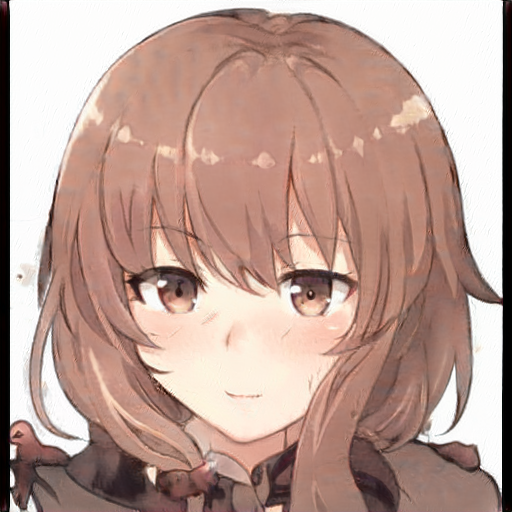

In [5]:
# Just build a single image, randomly
arrays, images = generate_from_latents([np.random.randn(1, Gs.input_shape[1])], 0.5)
images[0]

In [6]:
# Init randomizer, load latents
rnd = np.random # Could seed here if you want to
latents_a = rnd.randn(1, Gs.input_shape[1])
latents_b = rnd.randn(1, Gs.input_shape[1])
latents_c = rnd.randn(1, Gs.input_shape[1])

In [7]:
if os.path.exists("example_data/latents.npy"):
    latents_a, latents_b, latents_c = np.load("example_data/latents.npy")
np.save("example_data/latents.npy", np.array([latents_a, latents_b, latents_c]))

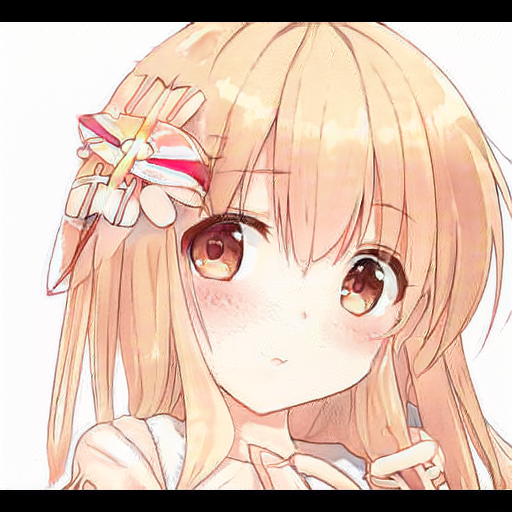

In [8]:
# Fixed input example, with dlatents as intermediate
dlatents = Gs.components.mapping.run(latents_a, None)[0]
PIL.Image.fromarray(generate_images_from_dlatents(dlatents, 0.7))

In [9]:
# Circular interpolation example. uncomment to make a cool movie.
"""
array_list = generate_from_generator_adaptive(circ_generator)
clip = moviepy.editor.ImageSequenceClip(array_list, fps=60)
clip.ipython_display()
clip.write_videofile("out.mp4")
"""

'\narray_list = generate_from_generator_adaptive(circ_generator)\nclip = moviepy.editor.ImageSequenceClip(array_list, fps=60)\nclip.ipython_display()\nclip.write_videofile("out.mp4")\n'

In [10]:
##
# 3. Projection - encoding images into latent space
##

# Projects an image into dlatent space and returns the dlatents
def encode_image(image, steps=1000, verbose=True):
    image_processed = np.array(copy.deepcopy(image).convert('RGB').resize((512, 512), resample = PIL.Image.LANCZOS)) / 255.0
    image_processed = (image_processed.transpose(2, 0, 1) - 0.5) * 2.0
    image_processed = np.array([image_processed])
    proj.num_steps = steps
    proj.start(image_processed)
    while proj.get_cur_step() < steps:
        if verbose:
            print('\rProjection: Step %d / %d ... ' % (proj.get_cur_step(), steps), end='', flush=True)
        proj.step()
    print('\r', end='', flush=True)
    return proj.get_dlatents()

In [11]:
# Note that projection has a random component - if you're not happy with the result, probably retry a few times
# For best results, probably have a single person facing the camera with a neutral white background
image = PIL.Image.open("input.png") # Default is toshiko koshijima
proj_dlatents = encode_image(image, 200)

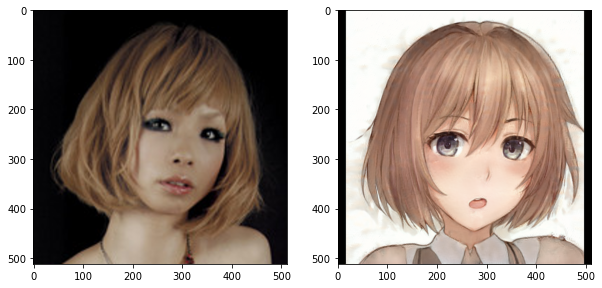

In [12]:
image_projected = generate_images_from_dlatents(proj_dlatents, 0.4)
plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.imshow(np.array(image))
plt.subplot(1, 2, 2)
plt.imshow(image_projected)

In [13]:
##
# 3. Modification - prepararing data for training dlatent dirs
##

# Generate samples to pass to the tagger model
def generate_one_for_latentdirs(truncation_psi = 0.7, randomize_noise = True):
    latents = rnd.randn(1, Gs.input_shape[1])
    dlatents = Gs.components.mapping.run(latents, None)[0]
    dlatents_trunc = truncate(dlatents, truncation_psi)
    fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    result_image = Gs.components.synthesis.run(
        dlatents_trunc.reshape((-1, 16, 512)),
        randomize_noise = randomize_noise,
        minibatch_size = 1,
        output_transform=fmt
    )[0]
    return latents, dlatents, result_image

# This gets slower as we go so lets go in steps of 100 to see if that alleviates the issue
# of course, this doesn't work, on account of my GPU memory being too small. minibatch 10, maybe?
# I want a ti 2080 11gb quite badly
def generate_many_for_latentdirs(truncation_psi = 0.7, randomize_noise = True):
    latents = rnd.randn(100, Gs.input_shape[1])
    dlatents = Gs.components.mapping.run(latents, None)
    dlatents_trunc = truncate(dlatents, truncation_psi)
    fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    result_image = Gs.components.synthesis.run(
        dlatents_trunc.reshape((-1, 16, 512)),
        randomize_noise = randomize_noise,
        minibatch_size = 10,
        output_transform=fmt
    )
    return latents, dlatents, result_image

In [14]:
# Unfortunately, stylegan 2 only runs on tf 1.14, while deepdanbooru current uses tf 2 - so we just save images here
# and tag them later (see DeepDanbooru-Playground notebook)
"""
latent_list = []
dlatent_list = []
image_list = []
image_count = 104000 # Increment to resume
while True:
    tags_exist = set(map(lambda x: x.split("_")[-1], glob.glob("image_tags_*")))
    tags_required = set(map(lambda x: x.split("_")[-1], glob.glob("dlatents_for_tagging_*")))
    tags_todo = sorted(list(tags_required.difference(tags_exist)))
    
    if len(tags_todo) > 0:
        print("Waiting for tagger, resuming in 120s, queue depth:", len(tags_todo))
        time.sleep(120)
    else:
        # Vary psi a little
        psi = 0.7
        if len(image_list) < 200:
            psi = 0.5
        if len(image_list) < 500:
            psi = 0.6

        latents, dlatents, image = generate_many_for_latentdirs(truncation_psi = psi)
        latent_list.extend(latents)
        dlatent_list.extend(dlatents)
        image_list.extend(image)
        #if len(image_list) % 100 == 0:
        print(".")

        image_count += 100
        if image_count % 1000 == 0:
            with open("dlatents_for_tagging_{}.pkl".format(image_count), 'wb') as f:
                pickle.dump((latent_list, dlatent_list, image_list), f)
            print("Wrote", "dlatents_for_tagging_{}.pkl".format(image_count))
            latent_list = []
            dlatent_list = []
            image_list = []
"""            

'\nlatent_list = []\ndlatent_list = []\nimage_list = []\nimage_count = 104000 # Increment to resume\nwhile True:\n    tags_exist = set(map(lambda x: x.split("_")[-1], glob.glob("image_tags_*")))\n    tags_required = set(map(lambda x: x.split("_")[-1], glob.glob("dlatents_for_tagging_*")))\n    tags_todo = sorted(list(tags_required.difference(tags_exist)))\n    \n    if len(tags_todo) > 0:\n        print("Waiting for tagger, resuming in 120s, queue depth:", len(tags_todo))\n        time.sleep(120)\n    else:\n        # Vary psi a little\n        psi = 0.7\n        if len(image_list) < 200:\n            psi = 0.5\n        if len(image_list) < 500:\n            psi = 0.6\n\n        latents, dlatents, image = generate_many_for_latentdirs(truncation_psi = psi)\n        latent_list.extend(latents)\n        dlatent_list.extend(dlatents)\n        image_list.extend(image)\n        #if len(image_list) % 100 == 0:\n        print(".")\n\n        image_count += 100\n        if image_count % 1000 ==

In [15]:
# Load the tags from the DeepDanbooru notebook, and probably re-load the latents, as we just restarted the kernel
"""
image_tags = []
latent_list = []
dlatent_list = []

tags_exist = set(map(lambda x: x.split("_")[-1], glob.glob("image_tags_*")))
for i in tags_exist:
    with open("image_tags_" + i, 'rb') as f:
        image_tags_tmp = pickle.load(f)
        
    with open("dlatents_for_tagging_" + i, 'rb') as f:    
        latent_list_tmp, dlatent_list_tmp, _ = pickle.load(f)
        
    image_tags.extend(image_tags_tmp)
    latent_list.extend(latent_list_tmp)
    dlatent_list.extend(list(np.array(dlatent_list_tmp).reshape(-1, 16, 512)[:, 0, :]))
    
gc.collect()
dlatents_for_regression = np.array(dlatent_list).reshape(-1, 512)    
"""    

'\nimage_tags = []\nlatent_list = []\ndlatent_list = []\n\ntags_exist = set(map(lambda x: x.split("_")[-1], glob.glob("image_tags_*")))\nfor i in tags_exist:\n    with open("image_tags_" + i, \'rb\') as f:\n        image_tags_tmp = pickle.load(f)\n        \n    with open("dlatents_for_tagging_" + i, \'rb\') as f:    \n        latent_list_tmp, dlatent_list_tmp, _ = pickle.load(f)\n        \n    image_tags.extend(image_tags_tmp)\n    latent_list.extend(latent_list_tmp)\n    dlatent_list.extend(list(np.array(dlatent_list_tmp).reshape(-1, 16, 512)[:, 0, :]))\n    \ngc.collect()\ndlatents_for_regression = np.array(dlatent_list).reshape(-1, 512)    \n'

In [16]:
# Turn into features for learning directions
"""
all_tags = collections.defaultdict(int)
for tags in image_tags:
    for tag in tags:
        all_tags[tag] += 1
tags_by_popularity = sorted(all_tags.items(), key = lambda x: x[1], reverse = True)
eye_tags = list(filter(lambda x: x[0].endswith("_eyes"), tags_by_popularity))
hair_tags = list(filter(lambda x: x[0].endswith("_hair"), tags_by_popularity))

tag_binary_feats = {}
tag_continuous_feats = {}
for tag, _ in tags_by_popularity:
    this_tag_feats = []
    this_tag_feats_cont = []
    for tag_list_for_dl in image_tags:
        this_dl_tag_value = 0.0
        this_dl_tag_value_cont = 0.0
        if tag in tag_list_for_dl:
            this_dl_tag_value = 1.0
            this_dl_tag_value_cont = tag_list_for_dl[tag]
        this_tag_feats.append(this_dl_tag_value)
        this_tag_feats_cont.append(this_dl_tag_value_cont)
    tag_binary_feats[tag] = np.array(this_tag_feats)
    tag_continuous_feats[tag] = np.array(this_tag_feats_cont)
"""    

'\nall_tags = collections.defaultdict(int)\nfor tags in image_tags:\n    for tag in tags:\n        all_tags[tag] += 1\ntags_by_popularity = sorted(all_tags.items(), key = lambda x: x[1], reverse = True)\neye_tags = list(filter(lambda x: x[0].endswith("_eyes"), tags_by_popularity))\nhair_tags = list(filter(lambda x: x[0].endswith("_hair"), tags_by_popularity))\n\ntag_binary_feats = {}\ntag_continuous_feats = {}\nfor tag, _ in tags_by_popularity:\n    this_tag_feats = []\n    this_tag_feats_cont = []\n    for tag_list_for_dl in image_tags:\n        this_dl_tag_value = 0.0\n        this_dl_tag_value_cont = 0.0\n        if tag in tag_list_for_dl:\n            this_dl_tag_value = 1.0\n            this_dl_tag_value_cont = tag_list_for_dl[tag]\n        this_tag_feats.append(this_dl_tag_value)\n        this_tag_feats_cont.append(this_dl_tag_value_cont)\n    tag_binary_feats[tag] = np.array(this_tag_feats)\n    tag_continuous_feats[tag] = np.array(this_tag_feats_cont)\n'

In [17]:
# Learn directions for tags (binarized) using logistic regression classification
# Thought: Why not apply L1 regu here to enforce sparsity?
# -> I feel this has neither improved nor worsened the situation (default settings)
# -> With really extreme sparsity constraint, it does, not work very well. Is my assumption that dlatents should be
#    sparse wrt tags wrong? Probably is.
# -> For now, plain logistic regression gives best results
def find_direction_binary(dlatents, targets):
    #clf = LogisticRegression(penalty="l1", solver="liblinear", max_iter=1000, C=0.001).fit(dlatents, targets)
    clf = LogisticRegression().fit(dlatents, targets)
    return np.repeat(clf.coef_.reshape(1,512), 16, axis = 0)

# Alternate version: Learn directions by fitting a linear regression onto the probabilities
# Questions:
# * Problem should be sparse - Lasso / Elasticnet?
#    -> ElasticNet does empathically Not work, regularizes everything to 0 (lol)
#    -> Same for Lasso :(
#    -> Lower alpha term? omit intercept?
#    -> seems like it would be really useful, though (not to mention faster), since we _expect_ sparsity here.
#    -> retry later with more data?
#    -> oh lol I'm fucking dumb why was I doing this with the inputs for every level. they're identical. there's just 512.
# * Not the most well-posed problem just generally -> really do need more samples. sighs.
# * Conclusion currently: Doesn't work all that well even though in theory it totally should
# * Or may it it would if you did not Fuck It Up you turbo moron. Retrying with not broken labels now.
#    -> suddenly it works great
def find_direction_continuous(dlatents, targets):
    clf = Lasso(alpha=0.01, fit_intercept=False).fit(dlatents, targets)
    if np.abs(np.sum(clf.coef_)) == 0.0:
        clf = Lasso(alpha=0.001, fit_intercept=False).fit(dlatents, targets)
    return  np.repeat(clf.coef_.reshape(1,512), 16, axis = 0)

# Alternate idea: Fit gauss mixture, gradient descend in that
# -> Ooooor, possibly: gauss mixture mapping kind of simultaneous likelihood maximization type stuff?
# -> that sounds super fun lets try it
# -> But first, the Super Baby Version: Just move towards weighted mean
# -> Works okish, but only okayish
def find_distrib_continuous(dlatents, targets):
    tag_mean = np.sum(dlatents * targets.reshape(-1, 1), axis = 0) / np.sum(targets)
    return  np.repeat(tag_mean.reshape(1,512), 16, axis = 0)

"""
popular_tags = list(filter(lambda x: x[1] > 5000 and x[1] < 95000, tags_by_popularity))
good_tags = popular_tags
"""

# Would still like to try to use the tagger network to do direct gradient descent of dlatents with tag loss

'\npopular_tags = list(filter(lambda x: x[1] > 5000 and x[1] < 95000, tags_by_popularity))\ngood_tags = popular_tags\n'

In [18]:
# Try to make the directions a bit more orthogonal
# In retrospect, this obviously works against stylegans own attempts to do the same thing, so e h
# -> it did not work very well
"""
dlatent_pca = PCA()
dlatent_pca.fit(dlatents_for_regression)
dlatents_for_regression_transformed = dlatent_pca.transform(dlatents_for_regression)
"""

'\ndlatent_pca = PCA()\ndlatent_pca.fit(dlatents_for_regression)\ndlatents_for_regression_transformed = dlatent_pca.transform(dlatents_for_regression)\n'

In [19]:
# Calculate actual directions for modifications
"""
tag_directions = {}
for i, (tag, _) in enumerate(good_tags):
    print("Estimating direction for", tag, "(", i, ")")
    # Variant A: Binary labels, logistic regression
    #tag_directions[tag] = find_direction_binary(dlatents_for_regression, tag_binary_feats[tag])
    
    # Variant B: Continuous labels (confidence from deepdanbooru), Lasso regression
    tag_directions[tag] = find_direction_continuous(dlatents_for_regression, tag_continuous_feats[tag])
    
    # Variant C: means and move to mean
    #tag_directions[tag] = find_distrib_continuous(dlatents_for_regression, tag_continuous_feats[tag])
with open("tagged_dlatents/tag_dirs_cont.pkl", 'wb') as f:
    pickle.dump(tag_directions, f)
"""    

'\ntag_directions = {}\nfor i, (tag, _) in enumerate(good_tags):\n    print("Estimating direction for", tag, "(", i, ")")\n    # Variant A: Binary labels, logistic regression\n    #tag_directions[tag] = find_direction_binary(dlatents_for_regression, tag_binary_feats[tag])\n    \n    # Variant B: Continuous labels (confidence from deepdanbooru), Lasso regression\n    tag_directions[tag] = find_direction_continuous(dlatents_for_regression, tag_continuous_feats[tag])\n    \n    # Variant C: means and move to mean\n    #tag_directions[tag] = find_distrib_continuous(dlatents_for_regression, tag_continuous_feats[tag])\nwith open("tagged_dlatents/tag_dirs_cont.pkl", \'wb\') as f:\n    pickle.dump(tag_directions, f)\n'

In [20]:
##
# 4. Modification - basic
##

with open("tagged_dlatents/tag_dirs_cont.pkl", 'rb') as f:
    tag_directions = pickle.load(f)

<StemContainer object of 3 artists>

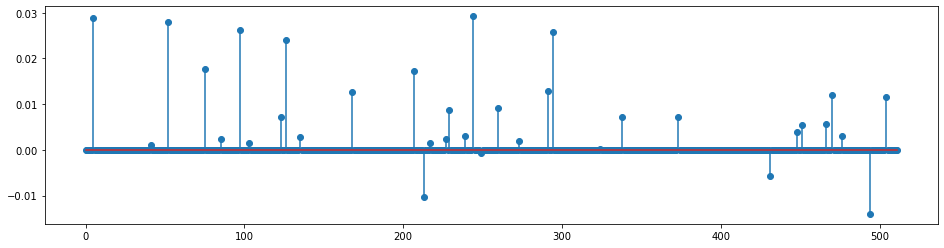

In [21]:
# Lets have a look at the weights.
# Sparse weights <=> most stems 
plt.figure(figsize=(16, 4))
plt.stem(tag_directions["face"][0,:])

In [22]:
# One possible idea: use only the top n (absolute value) weights to make the result sparser yet, top 1 in the extreme
# case (i.e. use ONLY one dimension)
# -> Does help disentangle some things (hairstyle and colour) but makes other things (hair colour and eye colour) worse
# -> Not really an improvement
"""
top_n = 10
for tag in tag_directions:
    top_list = np.argsort(np.abs(tag_directions[tag][0,:]))
    for i in range(16):
        tag_directions[tag][i,top_list[:-top_n]] = 0.0
"""        

'\ntop_n = 10\nfor tag in tag_directions:\n    top_list = np.argsort(np.abs(tag_directions[tag][0,:]))\n    for i in range(16):\n        tag_directions[tag][i,top_list[:-top_n]] = 0.0\n'

In [23]:
"""
# Do some modification and display on a grid (move-to-mean ver.)
dlatents_gen = Gs.components.mapping.run(latents_a, None)[0]

im = PIL.Image.new('RGB', (128 * 5, 128 * 5))
for i in range(0, 5):
    for j in range(0, 5):
        factor_hair = (i / 5.0) 
        factor_mouth = (j / 5.0)
    
        dlatents_mod = copy.deepcopy(dlatents_gen)
        #dlatents_mod = dlatent_pca.transform(dlatents_mod.reshape(1, 16*512)).reshape(16, 512)
        dlatents_mod = (1.0 - factor_hair) * dlatents_mod + tag_directions["black_hair"] * factor_hair
        dlatents_mod = (1.0 - factor_mouth) * dlatents_mod + tag_directions[":d"] * factor_mouth
        #dlatents_mod = dlatent_pca.inverse_transform(dlatents_mod.reshape(1, 16*512)).reshape(16, 512)
        
        dlatents_mod_image = generate_images_from_dlatents(dlatents_mod, 0.7)
        im.paste(PIL.Image.fromarray(dlatents_mod_image, 'RGB').resize((128, 128), resample = PIL.Image.LANCZOS), (128 * i, 128 * j))
im 
"""

'\n# Do some modification and display on a grid (move-to-mean ver.)\ndlatents_gen = Gs.components.mapping.run(latents_a, None)[0]\n\nim = PIL.Image.new(\'RGB\', (128 * 5, 128 * 5))\nfor i in range(0, 5):\n    for j in range(0, 5):\n        factor_hair = (i / 5.0) \n        factor_mouth = (j / 5.0)\n    \n        dlatents_mod = copy.deepcopy(dlatents_gen)\n        #dlatents_mod = dlatent_pca.transform(dlatents_mod.reshape(1, 16*512)).reshape(16, 512)\n        dlatents_mod = (1.0 - factor_hair) * dlatents_mod + tag_directions["black_hair"] * factor_hair\n        dlatents_mod = (1.0 - factor_mouth) * dlatents_mod + tag_directions[":d"] * factor_mouth\n        #dlatents_mod = dlatent_pca.inverse_transform(dlatents_mod.reshape(1, 16*512)).reshape(16, 512)\n        \n        dlatents_mod_image = generate_images_from_dlatents(dlatents_mod, 0.7)\n        im.paste(PIL.Image.fromarray(dlatents_mod_image, \'RGB\').resize((128, 128), resample = PIL.Image.LANCZOS), (128 * i, 128 * j))\nim \n'

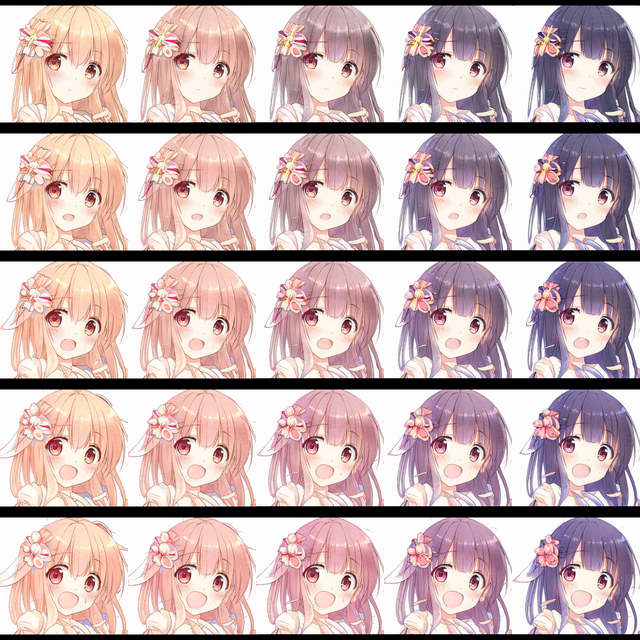

In [24]:
# Do some modification and display on a grid
dlatents_gen = Gs.components.mapping.run(latents_a, None)[0]

im = PIL.Image.new('RGB', (128 * 5, 128 * 5))
for i in range(0, 5):
    for j in range(0, 5):
        factor_hair = (i / 5.0) * 25.0
        factor_mouth = (j / 5.0) * 25.0
    
        dlatents_mod = copy.deepcopy(dlatents_gen)
        #dlatents_mod = dlatent_pca.transform(dlatents_mod.reshape(1, 16*512)).reshape(16, 512)
        dlatents_mod += -tag_directions["blonde_hair"] / np.linalg.norm(tag_directions["blonde_hair"]) * factor_hair \
                        +tag_directions["black_hair"] / np.linalg.norm(tag_directions["black_hair"]) * factor_hair
        dlatents_mod += -tag_directions["closed_mouth"] / np.linalg.norm(tag_directions["closed_mouth"]) * factor_mouth \
                        +tag_directions["open_mouth"] / np.linalg.norm(tag_directions["open_mouth"]) * factor_mouth
        #dlatents_mod = dlatent_pca.inverse_transform(dlatents_mod.reshape(1, 16*512)).reshape(16, 512)
        
        dlatents_mod_image = generate_images_from_dlatents(dlatents_mod, 0.7)
        im.paste(PIL.Image.fromarray(dlatents_mod_image, 'RGB').resize((128, 128), resample = PIL.Image.LANCZOS), (128 * i, 128 * j))
im    

In [25]:
# Remove some tags that are not all that helpful
tags_use = list(tag_directions.keys())

tags_use.remove("face")
tags_use.remove("portrait")
tags_use.remove("pillarboxed")
tags_use.remove("letterboxed")
tags_use.remove("frame")
tags_use.remove("border")
tags_use.remove("black_border")
tags_use.remove("close-up")
tags_use.remove("artist_name")

with open("tagged_dlatents/tags_use.pkl", 'wb') as f:
    pickle.dump(tags_use, f)

In [26]:
##
# 4. Modification - interactive
##
hair_eyes_only = False
    
tag_len = {}
for tag in tag_directions:
    tag_len[tag] = np.linalg.norm(tag_directions[tag].flatten())

mod_latents = copy.deepcopy(latents_a)
dlatents_gen = Gs.components.mapping.run(mod_latents, None)[0]  
def modify_and_sample(psi_pre, psi_post, truncate_pre, truncate_post, **kwargs):
    if truncate_pre == True:
        dlatents_mod = truncate(copy.deepcopy(dlatents_gen), psi_pre)
    else:
        dlatents_mod = copy.deepcopy(dlatents_gen)
        
    for tag in kwargs:
        dlatents_mod += tag_directions[tag] * kwargs[tag]  / tag_len[tag] * 25.0
    value_widgets["psi_pre"].value = str(round(psi_pre, 2))
    value_widgets["psi_post"].value = str(round(psi_post, 2))
    
    for tag in kwargs:
        tag_value = round((np.dot(dlatents_mod.flatten(), tag_directions[tag].flatten()) / tag_len[tag]), 2)
        value_widgets[tag].value = str(kwargs[tag]) + " | " + str(tag_value)
    
    display_psi = None
    if truncate_post == True:
        display_psi = psi_post
    display(PIL.Image.fromarray(generate_images_from_dlatents(dlatents_mod, truncation_psi = display_psi), 'RGB'))

psi_slider = widgets.FloatSlider(min = 0.0, max = 1.0, step = 0.01, value = 0.75, continuous_update = False, readout = False)
psi_slider_post = widgets.FloatSlider(min = 0.0, max = 1.0, step = 0.01, value = 0.65, continuous_update = False, readout = False)
if hair_eyes_only:
    modify_tags = [tag for tag in tag_directions if "_hair" in tag or "_eyes" in tag or "_mouth" in tag]
else:
    with open("tagged_dlatents/tags_use.pkl", "rb") as f:
        modify_tags = pickle.load(f)

tag_widgets = {}
for tag in modify_tags:
    tag_widgets[tag] = widgets.FloatSlider(min = -5.0, max = 5.0, step = 0.005, continuous_update = False, readout = False)
all_widgets = []

sorted_widgets = sorted(tag_widgets.items(), key = lambda x: x[0])
sorted_widgets = [("psi_pre", psi_slider), ("psi_post", psi_slider_post)] + sorted_widgets
value_widgets = {}
for widget in sorted_widgets:
    label_widget = widgets.Label(widget[0])
    label_widget.layout.width = "170px"
    
    value_widget = widgets.Label("0.0+100.0")
    value_widget.layout.width = "150px"
    value_widgets[widget[0]] = value_widget
    
    tag_hbox = widgets.HBox([label_widget, widget[1], value_widget])
    tag_hbox.layout.width = "320px"
    
    all_widgets.append(tag_hbox)

refresh = widgets.Button(description="New Sample")
modify = widgets.Button(description="Mutate")
reset_sliders = widgets.Button(description="Reset")
dlatent_encode = widgets.Button(description="Project input.png")

def new_sample(b):
    global mod_latents
    global dlatents_gen
    mod_latents = np.random.randn(1, Gs.input_shape[1])
    dlatents_gen = Gs.components.mapping.run(mod_latents, None)[0]  
    if psi_slider.value != 1.0:
        psi_slider.value += 0.00000000001
    else:
        psi_slider.value -= 0.00000000001
    
def mutate(b):
    global dlatents_gen
    mod_dlatents_add = np.random.randn(16, 512)
    dlatents_gen += mod_dlatents_add * 0.1
    if psi_slider.value != 1.0:
        psi_slider.value += 0.00000000001
    else:
        psi_slider.value -= 0.00000000001

def reset(b):
    for widget in tag_widgets:
        if not widget in ["truncate_pre", "truncate_post", "psi_pre", "psi_post"]:
            tag_widgets[widget].value = 0.0

def encode(b):
    global dlatents_gen
    image = PIL.Image.open("input.png")
    dlatents_gen = encode_image(image, encode_iters.value)
    if psi_slider.value != 1.0:
        psi_slider.value += 0.00000000001
    else:
        psi_slider.value -= 0.00000000001
            
truncate_pre = widgets.ToggleButton(value=False, description='Truncate Pre')
truncate_post = widgets.ToggleButton(value=True, description='Truncate Post')
refresh.on_click(new_sample)
modify.on_click(mutate)
reset_sliders.on_click(reset)
dlatent_encode.on_click(encode)

encode_iters = widgets.IntSlider(min = 10, max = 2000, step = 1, value=200, continuous_update = False, readout = True)

ui = widgets.Box(all_widgets + [refresh, modify, reset_sliders, truncate_pre, truncate_post, dlatent_encode, widgets.Label("Iterations"), encode_iters])
tag_widgets["psi_pre"] = psi_slider
tag_widgets["psi_post"] = psi_slider_post

ui.layout.flex_flow = 'row wrap'
ui.layout.display = 'inline-flex'
tag_widgets["truncate_pre"] = truncate_pre
tag_widgets["truncate_post"] = truncate_post

out = widgets.interactive_output(modify_and_sample, tag_widgets)

In [27]:
display(ui, out)

Box(children=(HBox(children=(Label(value='psi_pre', layout=Layout(width='170px')), FloatSlider(value=0.75, con…

Output()